In [14]:
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

In [15]:
train_dataset = datasets.MNIST(root='MNIST_data/', train=True,  # 학습 데이터
                               transform=transforms.ToTensor(), # 0~255까지의 값을 0~1 사이의 값으로 변환시켜줌
                               download=True)

test_dataset = datasets.MNIST(root='MNIST_data/', train=False,  # 테스트 데이터
                              transform=transforms.ToTensor(),  # 0~255까지의 값을 0~1 사이의 값으로 변환시켜줌
                              download=True)

In [16]:
print(len(train_dataset))

train_dataset_size = int(len(train_dataset) * 0.85)
validation_dataset_size = int(len(train_dataset) * 0.15)

train_dataset, validation_dataset = random_split(train_dataset, [train_dataset_size, validation_dataset_size])

print(len(train_dataset), len(validation_dataset), len(test_dataset))

60000
51000 9000 10000


In [17]:
BATCH_SIZE = 32

train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
class MyDeepLearningModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, data):
        data = self.flatten(data)
        data = self.fc1(data)
        data = self.relu(data)
        data = self.dropout(data)
        logits = self.fc2(data)
        return logits



model = MyDeepLearningModel()

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)

In [19]:
def model_train(dataloader, model, loss_function, optimizer):

    model.train()

    train_loss_sum = 0
    train_correct = 0
    train_total = 0

    total_train_batch = len(dataloader)

    for images, labels in dataloader: # images에는 이미지, labels에는 0-9 숫자

        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        x_train = images.view(-1, 28 * 28) #처음 크기는 (batch_size, 1, 28, 28) / 이걸 (batch_size, 784)로 변환
        y_train = labels

        outputs = model(x_train)
        loss = loss_function(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()

        train_total += y_train.size(0)  # label 열 사이즈 같음
        train_correct += ((torch.argmax(outputs, 1)==y_train)).sum().item() # 예측한 값과 일치한 값의 합

    train_avg_loss = train_loss_sum / total_train_batch
    train_avg_accuracy = 100*train_correct / train_total

    return (train_avg_loss, train_avg_accuracy)

In [20]:
def model_evaluate(dataloader, model, loss_function, optimizer):

    model.eval()

    with torch.no_grad(): #미분하지 않겠다는 것

        val_loss_sum = 0
        val_correct=0
        val_total = 0

        total_val_batch = len(dataloader)

        for images, labels in dataloader: # images에는 이미지, labels에는 0-9 숫자

            # reshape input image into [batch_size by 784]
            # label is not one-hot encoded
            x_val = images.view(-1, 28 * 28) #처음 크기는 (batch_size, 1, 28, 28) / 이걸 (batch_size, 784)로 변환
            y_val = labels

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()

            val_total += y_val.size(0)  # label 열 사이즈 같음
            val_correct += ((torch.argmax(outputs, 1)==y_val)).sum().item() # 예측한 값과 일치한 값의 합

        val_avg_loss = val_loss_sum / total_val_batch
        val_avg_accuracy = 100*val_correct / val_total

    return (val_avg_loss, val_avg_accuracy)

In [21]:
def model_test(dataloader, model):

    model.eval()

    with torch.no_grad(): #test set으로 데이터를 다룰 때에는 gradient를 주면 안된다.

        test_loss_sum = 0
        test_correct=0
        test_total = 0

        total_test_batch = len(dataloader)

        for images, labels in dataloader: # images에는 이미지, labels에는 0-9 숫자

            # reshape input image into [batch_size by 784]
            # label is not one-hot encoded
            x_test = images.view(-1, 28 * 28) #처음 크기는 (batch_size, 1, 28, 28) / 이걸 (batch_size, 784)로 변환
            y_test = labels

            outputs = model(x_test)
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)  # label 열 사이즈 같음
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item() # 예측한 값과 일치한 값의 합

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

        print('accuracy:', test_avg_accuracy)
        print('loss:', test_avg_loss)

In [22]:
from datetime import datetime

train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 30

for epoch in range(EPOCHS):

    #==============  model train  ================
    train_avg_loss, train_avg_accuracy = model_train(train_dataset_loader, model, loss_function, optimizer)  # training

    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)
    #=============================================

    #============  model evaluation  ==============
    val_avg_loss, val_avg_accuracy = model_evaluate(validation_dataset_loader, model, loss_function, optimizer)  # evaluation

    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)
    #============  model evaluation  ==============

    print('epoch:', '%02d' % (epoch + 1),
          'train loss =', '{:.4f}'.format(train_avg_loss), 'train accuracy =', '{:.4f}'.format(train_avg_accuracy),
          'validation loss =', '{:.4f}'.format(val_avg_loss), 'validation accuracy =', '{:.4f}'.format(val_avg_accuracy))

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

epoch: 01 train loss = 0.9867 train accuracy = 76.5510 validation loss = 0.4489 validation accuracy = 88.2444
epoch: 02 train loss = 0.4392 train accuracy = 87.8196 validation loss = 0.3471 validation accuracy = 90.1333
epoch: 03 train loss = 0.3666 train accuracy = 89.5882 validation loss = 0.3053 validation accuracy = 91.1889
epoch: 04 train loss = 0.3278 train accuracy = 90.7529 validation loss = 0.2749 validation accuracy = 92.1556
epoch: 05 train loss = 0.3005 train accuracy = 91.4922 validation loss = 0.2550 validation accuracy = 92.7667
epoch: 06 train loss = 0.2770 train accuracy = 92.1196 validation loss = 0.2345 validation accuracy = 93.3222
epoch: 07 train loss = 0.2561 train accuracy = 92.7098 validation loss = 0.2186 validation accuracy = 93.7333
epoch: 08 train loss = 0.2393 train accuracy = 93.1569 validation loss = 0.2055 validation accuracy = 94.1333
epoch: 09 train loss = 0.2257 train accuracy = 93.6196 validation loss = 0.1943 validation accuracy = 94.4667
epoch: 10 

In [23]:
# test dataset 으로 정확도 및 오차 테스트

model_test(test_dataset_loader, model)

accuracy: 97.33
loss: 0.09525532369611982


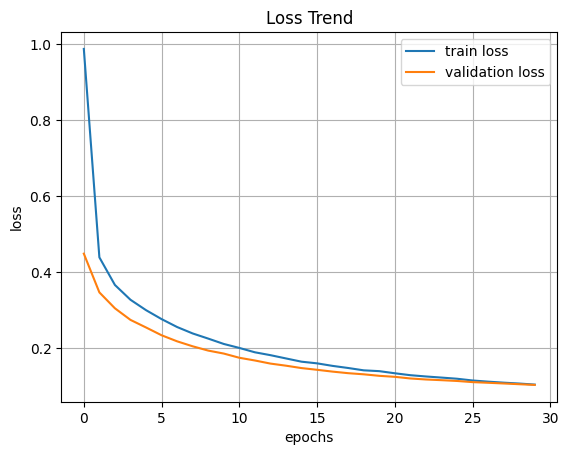

In [24]:
import matplotlib.pyplot as plt

plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')

plt.legend()

plt.show()

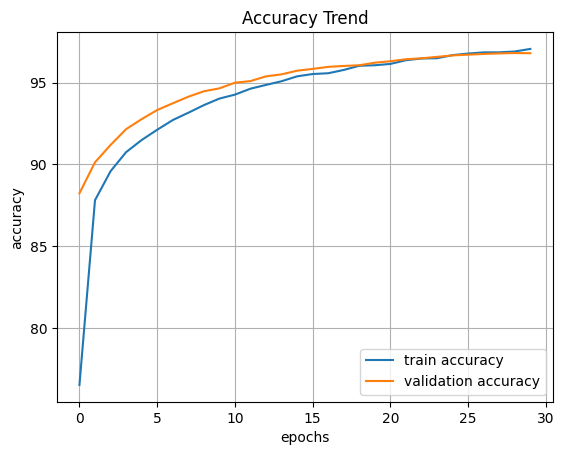

In [25]:
import matplotlib.pyplot as plt

plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')

plt.legend()

plt.show()

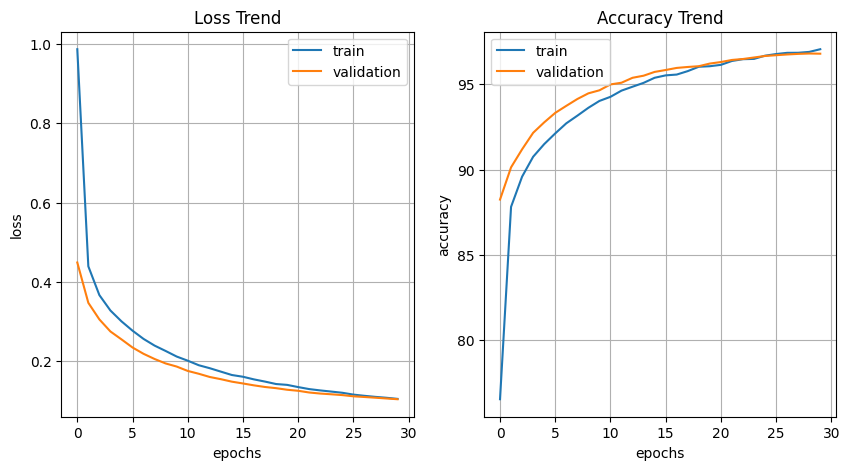

In [26]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.plot(train_accuracy_list, label='train')
plt.plot(val_accuracy_list, label='validation')
plt.legend()

plt.show()